In [1]:
from montlake.optimization.gradientgrouplasso import get_sr_lambda_parallel
from montlake.simulations.swissroll import get_swiss_roll_data, get_swiss_roll_gradients_noy_norotate, get_swiss_roll_gradients_noy
from montlake.geometry.geometry import get_geom, get_wlpca_tangent_sel, get_rm_tangent_sel
from montlake.utils.replicates import Replicate
from montlake.statistics.normalization import normalize_L212
from montlake.gradients.estimate import get_grads_pullback
from megaman.embedding import LTSA
from megaman.embedding import Isomap
from megaman.embedding import SpectralEmbedding
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from montlake.plotting.plotting import plot_reg_path_ax_lambdasearch_customcolors_names
from matplotlib import rcParams
from pylab import rcParams
import math
import seaborn as sns
from collections import OrderedDict
from matplotlib.patches import Rectangle
rcParams['figure.figsize'] = 25, 10

def width(p,w):
    if p > 1.:
        output = 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)
    else:
        output = w
    return(output)

def plot_reg_path_ax_lambdasearch_customcolors_names(axes, coeffs, xaxis, fig, colors, names):
    p = coeffs.shape[3]
    q = coeffs.shape[1]
    gnames = np.asarray(list(range(p)), dtype=str)

    rcParams['axes.titlesize'] = 30
    plt.rc('text', usetex=True)

    normax = np.sqrt(np.sum(np.sum(np.sum(coeffs ** 2, axis=1), axis=1), axis=1).max())

    for k in range(q):
        for j in range(p):
            toplot = np.linalg.norm(coeffs[:, k, :, j], axis=1)
            w = .15
            widths = np.asarray([width(xaxis[i], w) for i in range(len(xaxis))])
            axes[k + 1].plot(xaxis, toplot, 'go--', linewidth=10, markersize=0, alpha=1.,
                             color=colors[j], label=gnames[j])
    for j in range(p):
        toplot = np.linalg.norm(np.linalg.norm(coeffs[:, :, :, j], axis=2), axis=1)
        axes[0].plot(xaxis, toplot, 'go--', linewidth=10, markersize=0, alpha=.5,
                     color=colors[j], label=gnames[j])

    xax = xaxis.copy()
    xax.sort()

    for k in range(1 + q):
        axes[k].tick_params(labelsize=80)
        axes[k].set_yscale('symlog')
        #axes[k].set_xscale('symlog')
        axes[k].set_ylim(bottom=0, top=normax)
        if (k == 0):
            tixx = np.hstack(
                [np.asarray([0]), 10 ** np.linspace(math.floor(np.log10(normax)), math.floor(np.log10(normax)) + 1, 2)])
        if k != 0:
            axes[k].set_yticklabels([])
        if k != q:
            axes[k + 1].set_title(names[k], fontsize=90)
        if k == 0:
            axes[k].set_title("Combined", fontdict={'fontsize': 140})
    for k in range(1 + q):
        axes[k].grid(True, which="both", alpha=True)
        axes[k].set_xlabel(r"$\lambda$", fontsize=140)

    axes[0].set_ylabel(r"$||\beta_j||$", fontsize=140)

In [2]:
data, rotator, ts, ys = get_swiss_roll_data(n = 10000, theta =np.pi / 4,xvar = 0.00, rotate = False, b = 49)
radius = 1.88
n_neighbors = 100
geom = get_geom(data, radius, n_neighbors)  

/Users/samsonkoelle/miniconda3/envs/manifold_env_april/lib/python3.5/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [3]:
n_components = 2
b = 49
d = 2
spectral_embedding = SpectralEmbedding(n_components=n_components,eigen_solver='arpack',geom=geom)
embed_spectral = spectral_embedding.fit_transform(data)


/Users/samsonkoelle/miniconda3/envs/manifold_env_april/lib/python3.5/site-packages/sklearn/utils/validation.py:457: DeprecationWarning: Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  instead.
  " instead.", DeprecationWarning)


In [9]:
data, rotator, ts, ys = get_swiss_roll_data(n = 10000, theta =np.pi / 4,xvar = 0.001, rotate = False, b = 49)
radius = 1.88
n_neighbors = 100
geom = get_geom(data, radius, n_neighbors)  

n_components = 2
b = 49
d = 2
spectral_embedding = SpectralEmbedding(n_components=n_components,eigen_solver='arpack',geom=geom)
embed_spectral = spectral_embedding.fit_transform(data)

nreps = 1
nsel = 100 
replicates = {}
embedding = embed_spectral
for r in range(nreps):
    replicates[r] = Replicate(nsel = nsel, n = 10000)
    replicates[r].tangent_bases_M = get_wlpca_tangent_sel(data, geom, replicates[r].selected_points, d)
    replicates[r].tangent_bases_phi = get_rm_tangent_sel(embedding, geom, replicates[r].selected_points, d)
    replicates[r].dg_x = np.asarray([get_swiss_roll_gradients_noy_norotate(ts[replicates[r].selected_points[i]], b) for i in range(nsel)])
    replicates[r].dg_x_normalized = normalize_L212(replicates[r].dg_x)
    replicates[r].dg_M = np.einsum('i b p, i b d -> i d p', replicates[r].dg_x_normalized, replicates[r].tangent_bases_M)
    replicates[r].dphispectral_M = get_grads_pullback(data,  embedding, geom, replicates[r].tangent_bases_M, replicates[r].tangent_bases_phi, replicates[r].selected_points)
    replicates[r].dphispectral_M_normalized = normalize_L212(replicates[r].dphispectral_M)
    
gl_itermax = 500
r = 0
max_search = 30
reg_l2 = 0.
tol = 1e-14
learning_rate = 100
replicates[r].results = get_sr_lambda_parallel(replicates[r].dphispectral_M_normalized , replicates[r].dg_M, gl_itermax,reg_l2, max_search, d, tol,learning_rate)


/Users/samsonkoelle/miniconda3/envs/manifold_env_april/lib/python3.5/site-packages/sklearn/utils/validation.py:457: DeprecationWarning: Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  instead.
  " instead.", DeprecationWarning)


initializing lambda search
converged 9.964002621782923
0 4.982001310891461 probe
converged 4.982001310891461
1 2.4910006554457307 probe
converged 2.4910006554457307
2 1.2455003277228653 probe
converged 1.2455003277228653
3 0.6227501638614327 probe
converged 0.6227501638614327
4 0.31137508193071634 probe
converged 0.31137508193071634
5 0.15568754096535817 probe
Selected functions [ 0 46]


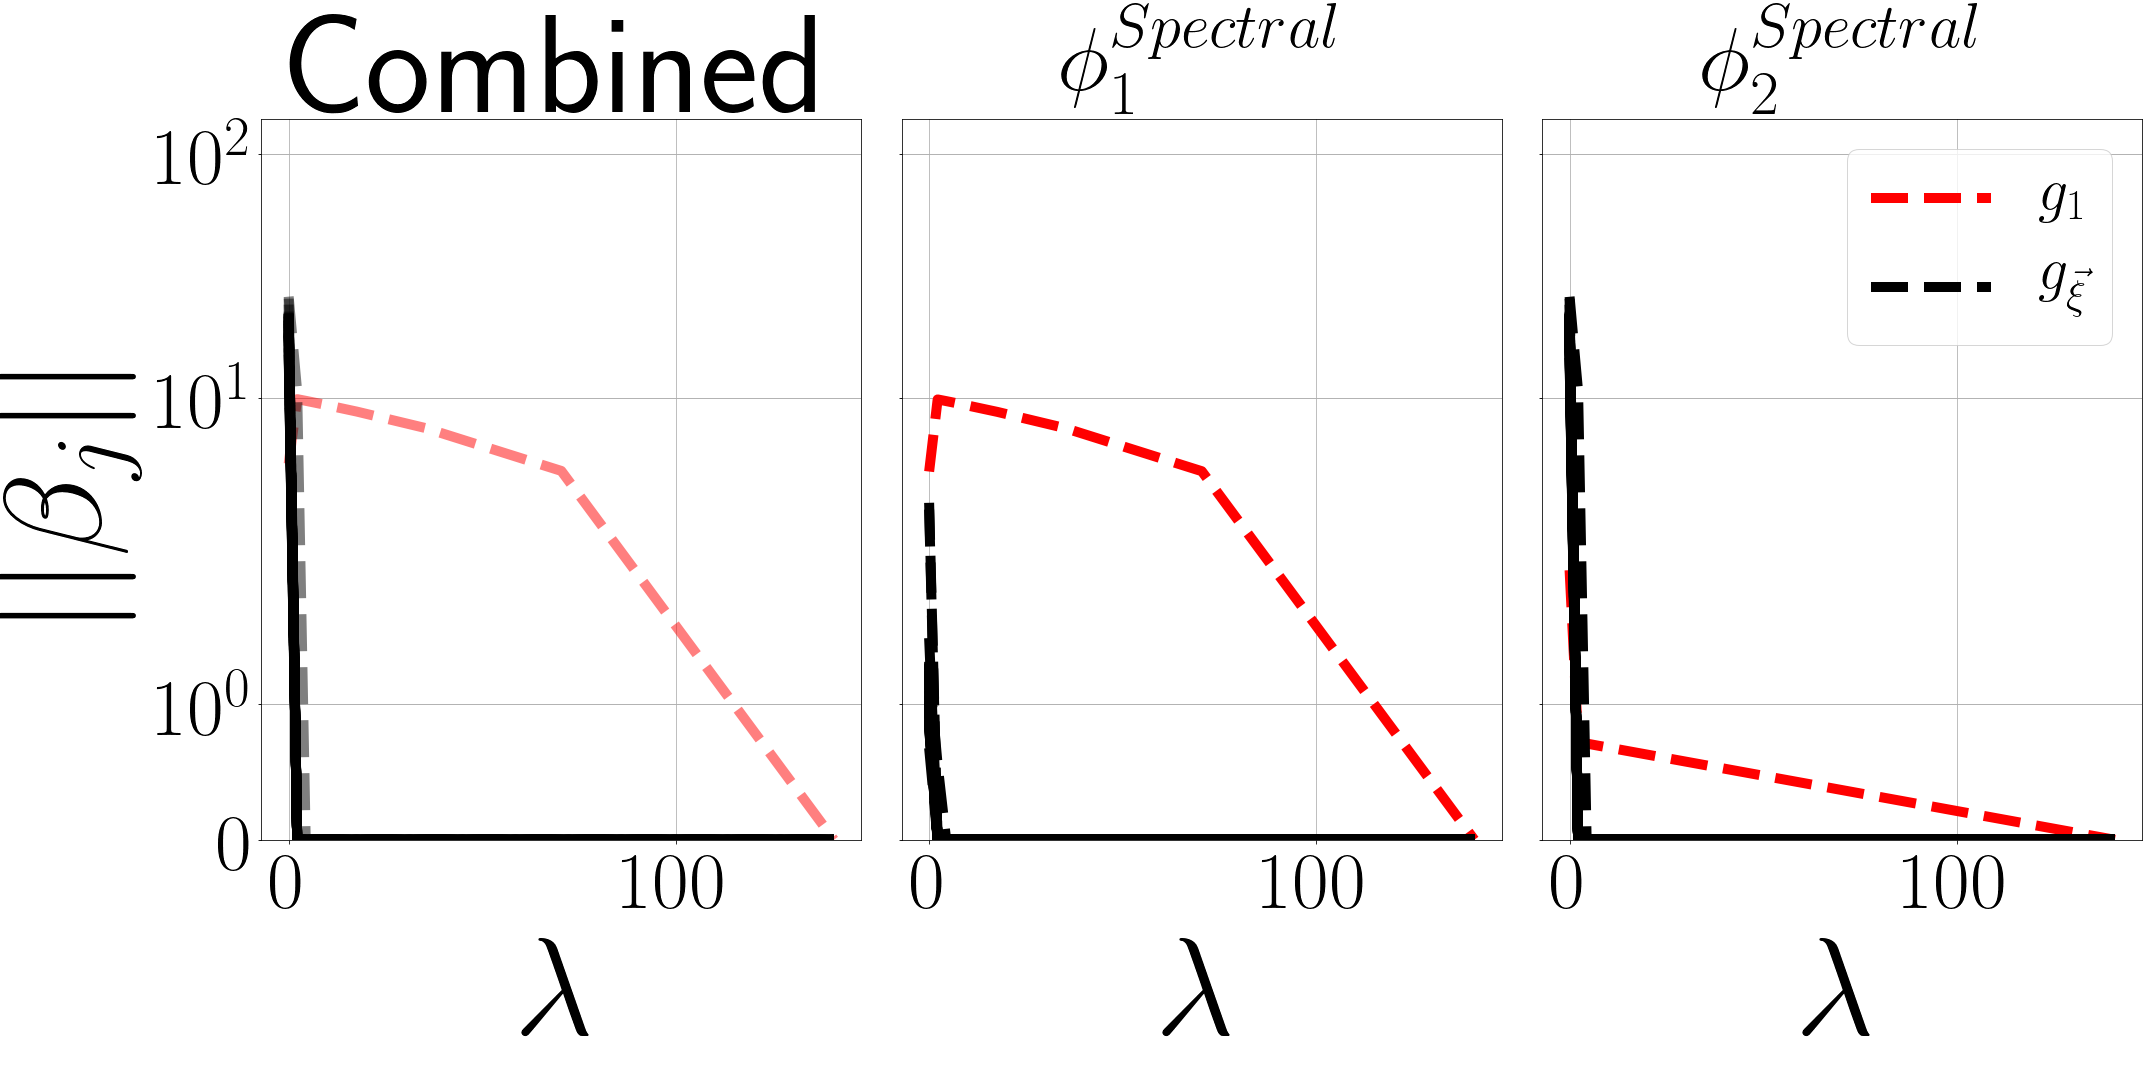

In [11]:
m = 2
colors = np.hstack([np.repeat('red',1), np.repeat('black',50)])
replicates[r].get_ordered_axes()

%matplotlib inline
matplotlib.rc('font', family='sans-serif')
fig, axes_all = plt.subplots(1,3, figsize=(30,15) )
names = [r'$\phi_1^{Spectral}$', r'$\phi_2^{Spectral}$']
plot_reg_path_ax_lambdasearch_customcolors_names(axes_all, replicates[0].cs_reorder, replicates[0].xaxis_reorder * np.sqrt(m * nsel), fig,colors, names)
axes_all[2].legend([r'$g_1$', r'$g_{\vec \xi}$'], fontsize = 60)
plt.tight_layout()
plt.savefig('/Users/samsonkoelle/mani-samk-gradients/Figures/jmlr_minorrevision/sr_missing', bbox_inches = "tight")

In [12]:
data, rotator, ts, ys = get_swiss_roll_data(n = 10000, theta =np.pi / 4,xvar = 0.00, rotate = True, b = 49)
radius = 1.88
n_neighbors = 100
geom = get_geom(data, radius, n_neighbors)  

n_components = 2
b = 49
d = 2
spectral_embedding = SpectralEmbedding(n_components=n_components,eigen_solver='arpack',geom=geom)
embed_spectral = spectral_embedding.fit_transform(data)

nreps = 1
nsel = 100 
replicates = {}
embedding = embed_spectral
for r in range(nreps):
    replicates[r] = Replicate(nsel = nsel, n = 10000)
    replicates[r].tangent_bases_M = get_wlpca_tangent_sel(data, geom, replicates[r].selected_points, d)
    replicates[r].tangent_bases_phi = get_rm_tangent_sel(embedding, geom, replicates[r].selected_points, d)
    replicates[r].dg_x = np.asarray([get_swiss_roll_gradients_noy(ts[replicates[r].selected_points[i]], rotator,b) for i in range(nsel)])
    replicates[r].dg_x_normalized = normalize_L212(replicates[r].dg_x)
    replicates[r].dg_M = np.einsum('i b p, i b d -> i d p', replicates[r].dg_x_normalized, replicates[r].tangent_bases_M)
    replicates[r].dphispectral_M = get_grads_pullback(data,  embedding, geom, replicates[r].tangent_bases_M, replicates[r].tangent_bases_phi, replicates[r].selected_points)
    replicates[r].dphispectral_M_normalized = normalize_L212(replicates[r].dphispectral_M)
    
gl_itermax = 500
r = 0
max_search = 30
reg_l2 = 0.
tol = 1e-14
learning_rate = 100
replicates[r].results = get_sr_lambda_parallel(replicates[r].dphispectral_M_normalized , replicates[r].dg_M, gl_itermax,reg_l2, max_search, d, tol,learning_rate)

/Users/samsonkoelle/miniconda3/envs/manifold_env_april/lib/python3.5/site-packages/sklearn/utils/validation.py:457: DeprecationWarning: Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  instead.
  " instead.", DeprecationWarning)


initializing lambda search
converged 10.002916592527827
0 5.001458296263913 probe
converged 5.001458296263913
1 2.5007291481319567 probe
converged 2.5007291481319567
Selected functions [ 0 30]


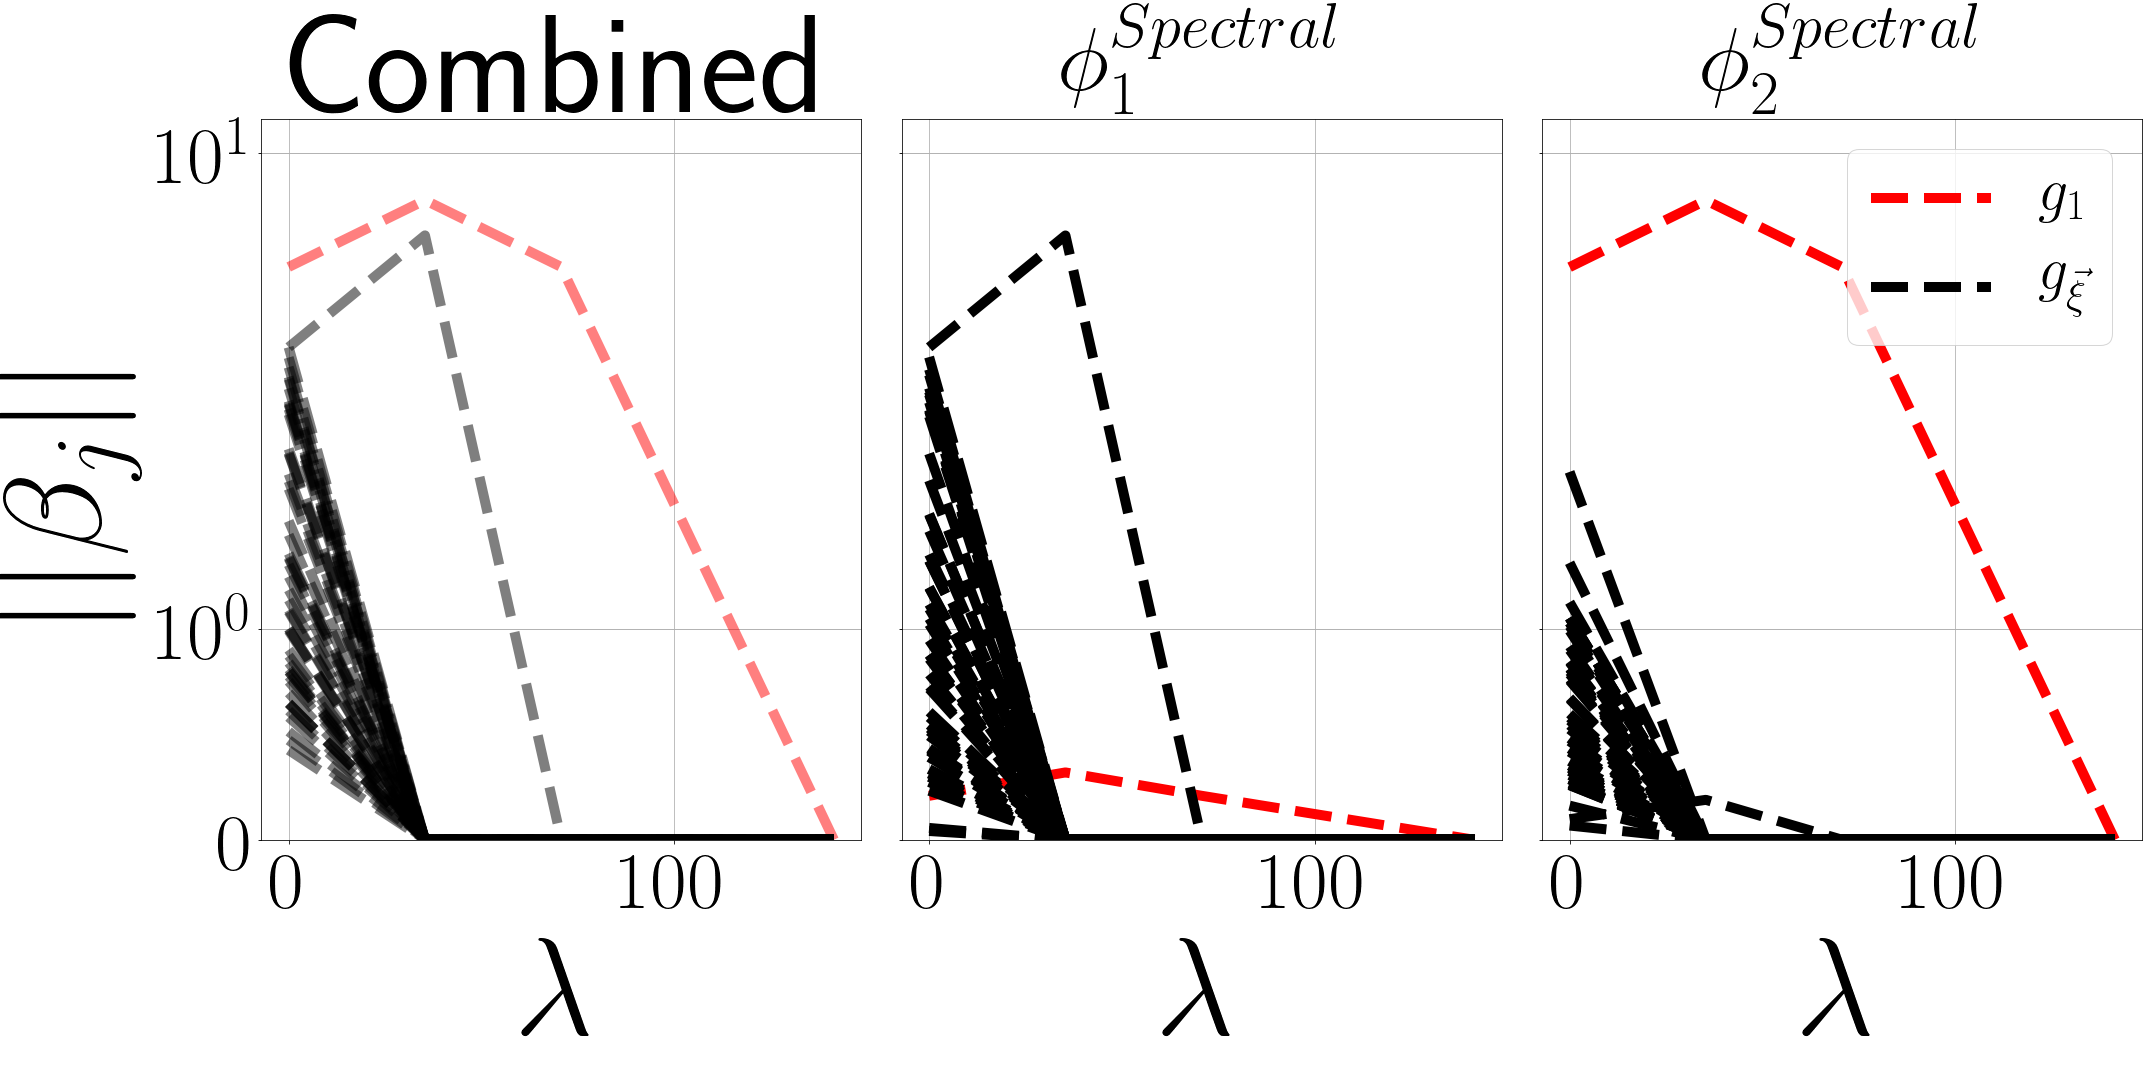

In [13]:
import matplotlib
m = 2
colors = np.hstack([np.repeat('red',1),np.repeat('black',49)])
replicates[r].get_ordered_axes()

%matplotlib inline
matplotlib.rc('font', family='sans-serif')
fig, axes_all = plt.subplots(1,3, figsize=(30,15) )
names = [r'$\phi_1^{Spectral}$', r'$\phi_2^{Spectral}$']
plot_reg_path_ax_lambdasearch_customcolors_names(axes_all, replicates[0].cs_reorder, replicates[0].xaxis_reorder * np.sqrt(m * nsel), fig,colors, names)
axes_all[2].legend([r'$g_1$', r'$g_{\vec \xi}$'], fontsize = 60)
plt.tight_layout()
plt.savefig('/Users/samsonkoelle/mani-samk-gradients/Figures/jmlr_minorrevision/sr_missing_rotated', bbox_inches = "tight")
